In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

In [2]:
meg = pd.read_csv('Meg Price History - Hoja 1.csv')
pta = pd.read_csv('PTA Price History - Hoja 1.csv')

##### Análisis de la información y limpieza

In [3]:
meg.head()

,Fecha,MEG c/lb
0,2/03/2018 0:00:00,"54,34"
1,9/03/2018 0:00:00,"54,34"
2,16/03/2018 0:00:00,"54,34"
3,23/03/2018 0:00:00,"54,34"
4,29/03/2018 0:00:00,"52,84"


In [4]:
pta.head()

,Fecha,PTA c/lb
0,2/03/2018 0:00:00,"48,18"
1,9/03/2018 0:00:00,"48,18"
2,16/03/2018 0:00:00,"48,18"
3,23/03/2018 0:00:00,"48,18"
4,29/03/2018 0:00:00,"48,01"


In [5]:
meg['Fecha']= meg['Fecha'].str.replace('/', '-')

In [6]:
pta['Fecha']= pta['Fecha'].str.replace('/', '-')

In [7]:
meg['MEG c/lb']= meg['MEG c/lb'].str.replace(',', '.')

In [8]:
pta['PTA c/lb']= pta['PTA c/lb'].str.replace(',', '.')

In [9]:
meg['MEG c/lb'] = meg['MEG c/lb'].astype('float64')

In [10]:
pta['PTA c/lb'] = pta['PTA c/lb'].astype('float64')

In [11]:
meg['Fecha'] = pd.to_datetime(meg['Fecha'])

In [12]:
pta['Fecha'] = pd.to_datetime(pta['Fecha'])

In [13]:
pta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Fecha     237 non-null    datetime64[ns]
 1   PTA c/lb  237 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.8 KB


In [14]:
meg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Fecha     237 non-null    datetime64[ns]
 1   MEG c/lb  237 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.8 KB


In [15]:
meg = meg.set_index('Fecha')

In [16]:
pta = pta.set_index('Fecha')

In [17]:
meg.head()

,MEG c/lb
Fecha,
2018-02-03,54.34
2018-09-03,54.34
2018-03-16,54.34
2018-03-23,54.34
2018-03-29,52.84


In [18]:
pta.head()

,PTA c/lb
Fecha,
2018-02-03,48.18
2018-09-03,48.18
2018-03-16,48.18
2018-03-23,48.18
2018-03-29,48.01


In [19]:
pta.tail()

,PTA c/lb
Fecha,
2022-10-28,71.0
2022-04-11,69.0
2022-11-11,69.0
2022-11-18,69.0
2022-11-25,69.0


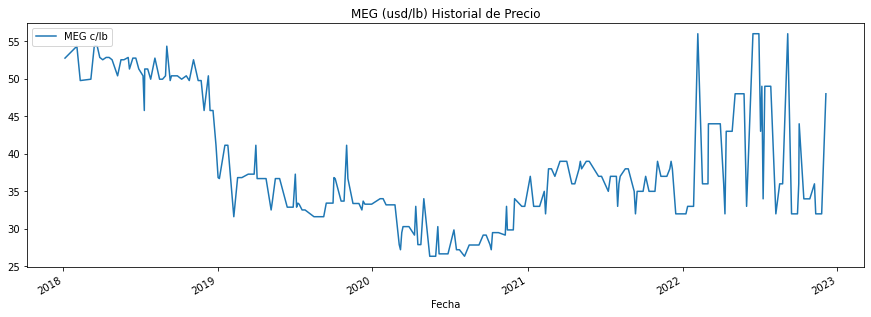

In [20]:
meg.plot(figsize=(15, 5),title='MEG (usd/lb) Historial de Precio')
plt.show()

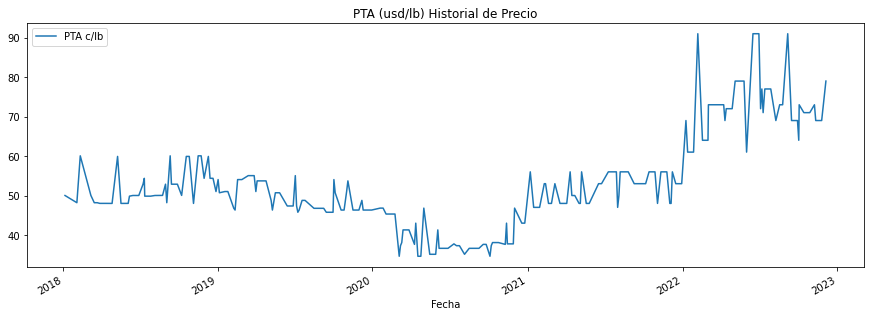

In [21]:
pta.plot(figsize=(15, 5),title='PTA (usd/lb) Historial de Precio')
plt.show()

In [22]:
meg1=meg.copy()

In [23]:
pta1=pta.copy()

##### Entrenamiento de los datos

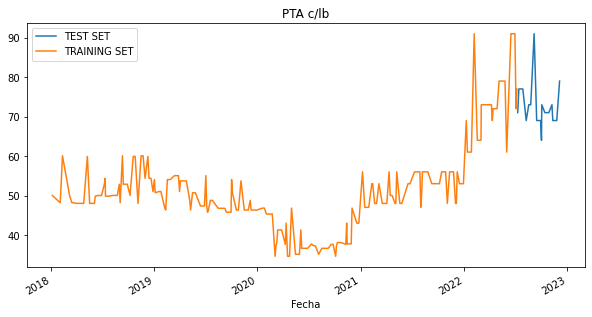

In [24]:
split_date = '7-Jul-2022'
pta1_train = pta1.loc[pta1.index <= split_date].copy()
pta1_test = pta1.loc[pta1.index > split_date].copy()

# Plot train and test so you can see where we have split
pta1_test \
    .rename(columns={'PTA c/lb': 'TEST SET'}) \
    .join(pta1_train.rename(columns={'PTA c/lb': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='PTA c/lb', ms=1)
plt.show()

In [25]:
pta1_train_prophet = pta1_train.reset_index() \
    .rename(columns={'Fecha':'ds',
                     'PTA c/lb':'y'})

In [26]:
pta1_train_prophet

,ds,y
0,2018-02-03,48.18
1,2018-09-03,48.18
2,2018-03-16,48.18
3,2018-03-23,48.18
4,2018-03-29,48.01
...,...,...
211,2022-06-30,91.00
212,2022-07-07,77.00
213,2022-04-08,73.00
214,2022-01-09,69.00


In [27]:
model = Prophet()
model.fit(pta1_train_prophet)

18:39:48 - cmdstanpy - INFO - Chain [1] start processing
18:39:48 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
pta1_test_prophet = pta1_test.reset_index() \
    .rename(columns={'Fecha':'ds',
                     'PTA c/lb':'y'})

pta1_test_fcst = model.predict(pta1_test_prophet)

In [29]:
pta1_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-07-10,75.468184,71.213692,82.498461,75.468184,75.468184,1.412807,1.412807,1.412807,0.788155,0.788155,0.788155,0.624652,0.624652,0.624652,0.0,0.0,0.0,76.880991
1,2022-07-14,75.739611,70.544953,82.354353,75.738078,75.741377,1.064741,1.064741,1.064741,1.242893,1.242893,1.242893,-0.178153,-0.178153,-0.178153,0.0,0.0,0.0,76.804352
2,2022-07-21,76.214609,70.468010,82.178854,76.198326,76.230646,0.300033,0.300033,0.300033,1.242893,1.242893,1.242893,-0.942860,-0.942860,-0.942860,0.0,0.0,0.0,76.514643
3,2022-07-28,76.689607,70.312282,83.114465,76.649904,76.725312,0.272478,0.272478,0.272478,1.242893,1.242893,1.242893,-0.970415,-0.970415,-0.970415,0.0,0.0,0.0,76.962085
4,2022-08-09,77.503888,71.551729,83.813369,77.434072,77.568004,0.216256,0.216256,0.216256,1.149519,1.149519,1.149519,-0.933263,-0.933263,-0.933263,0.0,0.0,0.0,77.720144


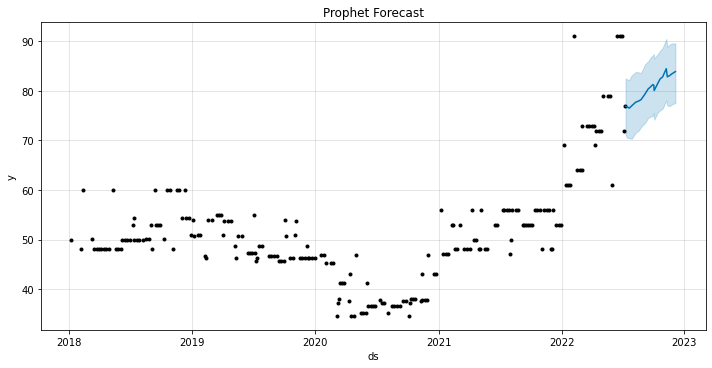

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pta1_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

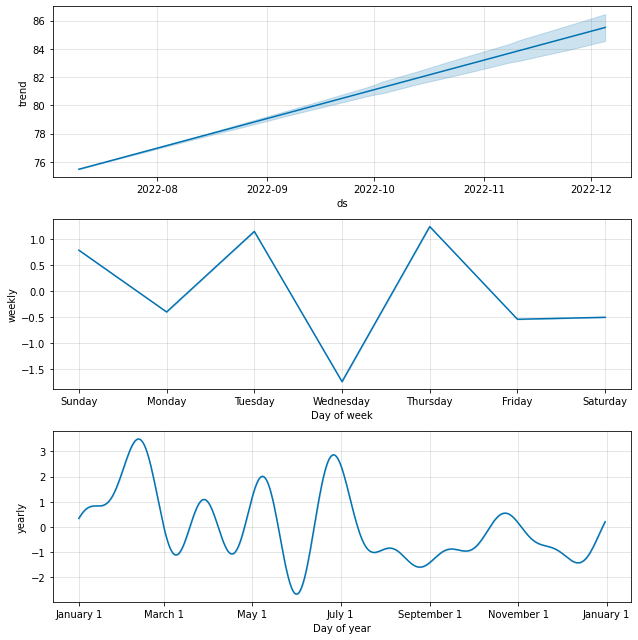

In [31]:
fig = model.plot_components(pta1_test_fcst)
plt.show()

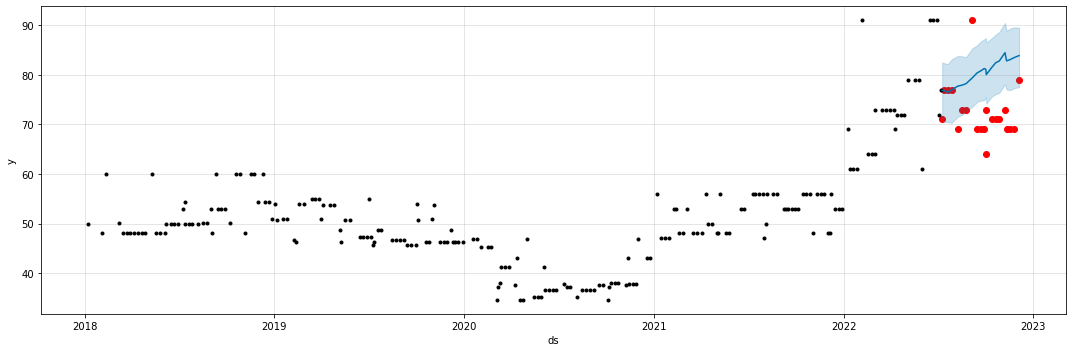

In [32]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pta1_test.index, pta1_test['PTA c/lb'], color='r')
fig = model.plot(pta1_test_fcst, ax=ax)

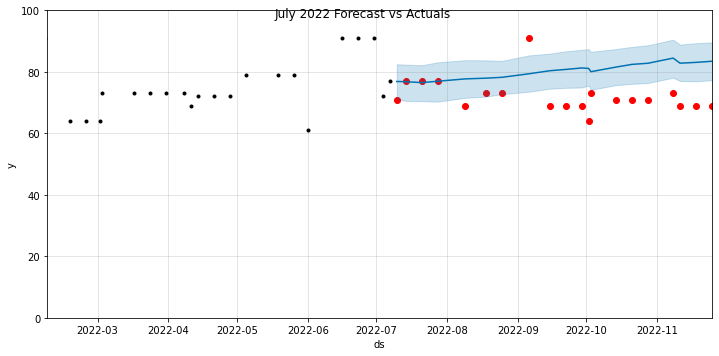

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pta1_test.index, pta1_test['PTA c/lb'], color='r')
fig = model.plot(pta1_test_fcst, ax=ax)
ax.set_xbound(lower='02-07-2022',
              upper='25-11-2022')
ax.set_ylim(0, 100)
plot = plt.suptitle('July 2022 Forecast vs Actuals')

In [34]:
np.sqrt(mean_squared_error(y_true=pta1_test['PTA c/lb'],
                   y_pred=pta1_test_fcst['yhat']))

10.560725914505108

In [35]:
mean_absolute_error(y_true=pta1_test['PTA c/lb'],
                   y_pred=pta1_test_fcst['yhat'])

9.414828787070288

In [36]:
# Calculates MAPE given y_true and y_pred
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [37]:
mean_absolute_percentage_error(y_true=pta1_test['PTA c/lb'],
                   y_pred=pta1_test_fcst['yhat'])

13.247043622667261

In [38]:
future = model.make_future_dataframe(periods=365, include_history=False)

In [39]:
forecast_pta = model.predict(future)

In [40]:
forecast_pta.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
360,2023-07-03,99.760919,94.182350,108.940724,95.750090,103.542467,1.820728,1.820728,1.820728,-0.399117,-0.399117,-0.399117,2.219846,2.219846,2.219846,0.0,0.0,0.0,101.581647
361,2023-07-04,99.828776,95.881870,110.318294,95.807140,103.623048,3.175950,3.175950,3.175950,1.149519,1.149519,1.149519,2.026431,2.026431,2.026431,0.0,0.0,0.0,103.004725
362,2023-07-05,99.896632,92.510652,107.105959,95.858174,103.703630,0.078171,0.078171,0.078171,-1.739612,-1.739612,-1.739612,1.817783,1.817783,1.817783,0.0,0.0,0.0,99.974803
363,2023-07-06,99.964489,95.371550,110.024151,95.909207,103.784211,2.840672,2.840672,2.840672,1.242893,1.242893,1.242893,1.597778,1.597778,1.597778,0.0,0.0,0.0,102.805161
364,2023-07-07,100.032346,93.106141,107.829777,95.960241,103.865049,0.830317,0.830317,0.830317,-0.539988,-0.539988,-0.539988,1.370305,1.370305,1.370305,0.0,0.0,0.0,100.862663


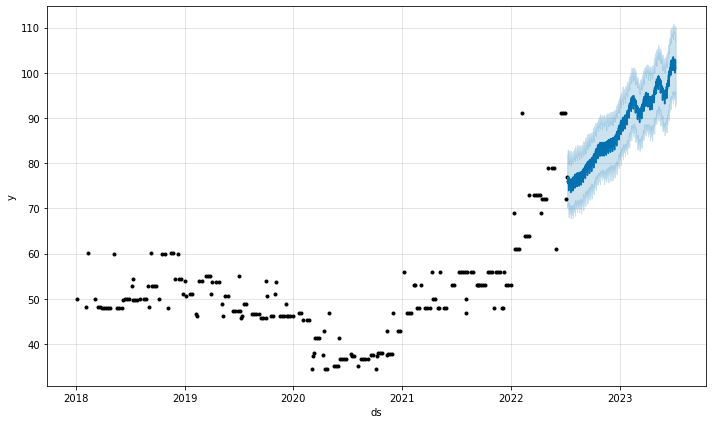

In [41]:
fig1 = model.plot(forecast_pta)

In [42]:
filename = 'forecast_pta.csv'
forecast_pta.to_csv(filename,index=False)
print('Saved file: ' + filename)

Saved file: forecast_pta.csv
